In [2]:
import pandas as pd
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.sql.functions import datediff, to_date, lit
from datetime import datetime, timedelta
import datetime

In [4]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
conf = SparkConf()

conf = conf.set("spark.executor.instances", 10)
conf = conf.set("spark.executor.memory","16g")
conf = conf.set("spark.executor.cores",2)
conf = conf.set("spark.jars","/home/cdsw/P93719-Said/business-development/libraries/jdbc/db2jcc4.jar")
appName="checking"

In [5]:
spark = SparkSession \
    .builder.config(conf=conf) \
    .appName(appName) \
    .config('spark.dynamicAllocation.enabled', 'false') \
    .config("spark.blacklist.enabled", 'false') \
    .config("spark.rpc.message.maxSize", '256') \
    .config("spark.sql.legacy.allowCreatingManagedTableUsingNonemptyLocation","true") \
    .config('spark.executor.instances', '5') \
    .config('spark.executor.cores', '6') \
    .config('spark.executor.memory', '36g') \
    .config('spark.yarn.executor.memoryOverhead', '10g') \
    .config('spark.io.compression.codec', 'snappy') \
    .enableHiveSupport() \
    .getOrCreate()

In [6]:
spark

In [7]:
data = pd.read_csv("test.csv", encoding = "ISO-8859-1")
data = data[['STNAME', 'CTYNAME', 'CENSUS2010POP']]
data.rename(columns={'CENSUS2010POP' : 'jml'}, inplace = True)
data.drop(index=data.index[0], 
        axis=0, 
        inplace=True)

In [8]:
data.head(3)

,STNAME,CTYNAME,jml
1,Alabama,Autauga County,54571
2,Alabama,Baldwin County,182265
3,Alabama,Barbour County,27457


In [9]:
sp_data = spark.createDataFrame(data)

In [10]:
sp_data.show(3,False)

+-------+--------------+------+
|STNAME |CTYNAME       |jml   |
+-------+--------------+------+
|Alabama|Autauga County|54571 |
|Alabama|Baldwin County|182265|
|Alabama|Barbour County|27457 |
+-------+--------------+------+
only showing top 3 rows



In [11]:
sp_data.registerTempTable("sp_data")

In [36]:
spark.sql(""" 
select sum(frekuensi) jml
from
                (select digit_pertama, count(1) frekuensi
                from
                (select *, left(jml,1) digit_pertama from sp_data)
                group by
                digit_pertama
                order by
                digit_pertama) """).show(3,False)

+----+
|jml |
+----+
|3192|
+----+



In [35]:
spark.sql("""
with checking as  
                (select digit_pertama, count(1) frekuensi
                from
                (select *, left(jml,1) digit_pertama from sp_data)
                group by
                digit_pertama
                order by
                digit_pertama)

select digit_pertama, frekuensi, round((frekuensi/s.total)*100,2) persentasi_digit, 
round(round(log(10,1 + (1/digit_pertama)),3)*100,1) benford_law
from checking
cross join (select sum(frekuensi) as total from checking) s

""").show(30,False)

+-------------+---------+----------------+-----------+
|digit_pertama|frekuensi|persentasi_digit|benford_law|
+-------------+---------+----------------+-----------+
|1            |965      |30.23           |30.1       |
|2            |601      |18.83           |17.6       |
|3            |379      |11.87           |12.5       |
|4            |311      |9.74            |9.7        |
|5            |219      |6.86            |7.9        |
|6            |218      |6.83            |6.7        |
|7            |183      |5.73            |5.8        |
|8            |156      |4.89            |5.1        |
|9            |160      |5.01            |4.6        |
+-------------+---------+----------------+-----------+



In [37]:
pd_final = spark.sql("""
with checking as  
                (select digit_pertama, count(1) frekuensi
                from
                (select *, left(jml,1) digit_pertama from sp_data)
                group by
                digit_pertama
                order by
                digit_pertama)

select digit_pertama, frekuensi, round((frekuensi/s.total)*100,2) persentasi_digit, 
round(round(log(10,1 + (1/digit_pertama)),3)*100,1) benford_law
from checking
cross join (select sum(frekuensi) as total from checking) s

""").persist().toPandas()

In [38]:
pd_final

,digit_pertama,frekuensi,persentasi_digit,benford_law
0,1,965,30.23,30.1
1,2,601,18.83,17.6
2,3,379,11.87,12.5
3,4,311,9.74,9.7
4,5,219,6.86,7.9
5,6,218,6.83,6.7
6,7,183,5.73,5.8
7,8,156,4.89,5.1
8,9,160,5.01,4.6


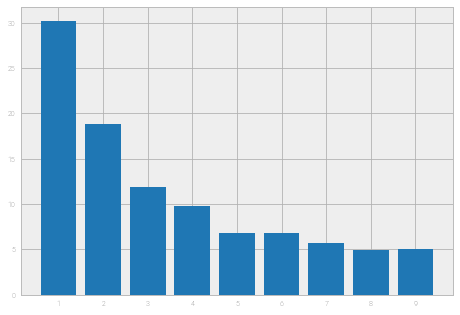

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
digit = pd_final.digit_pertama
persentasi = pd_final.persentasi_digit
ax.bar(digit, persentasi)
plt.show()

In [44]:
pd_final = pd_final.set_index('digit_pertama')

In [45]:
pd_final

,frekuensi,persentasi_digit,benford_law
digit_pertama,,,
1,965,30.23,30.1
2,601,18.83,17.6
3,379,11.87,12.5
4,311,9.74,9.7
5,219,6.86,7.9
6,218,6.83,6.7
7,183,5.73,5.8
8,156,4.89,5.1
9,160,5.01,4.6


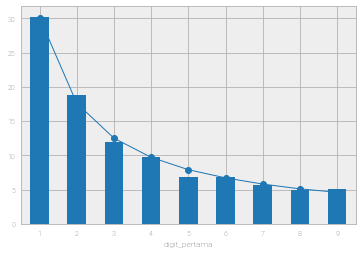

In [46]:
ax = pd_final.persentasi_digit.plot(kind='bar')
pd_final.iloc[:,-1].plot(linestyle='-', marker='o', ax = ax)